# Measuring Equity Risk

> TBC

- toc: true
- badges: true
- hide: false
- author: Stephen Lemasney

In this notebook we'll explore two statistical methods for calculating Equity Risk:

1. Variance: fluctuation of stock return from its mean
2. VaR: the maximum an investor could loose (within a confidence interval)

For the purposes of this notebook, we'll explore the above looking at the risk of Apple (ticker = AAPL).

## Import packages and setup configurations

In [1]:
# Import all the required packages
import requests
import json
import datetime
import os

# Import data wrangling packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use Python's "magic" commands since we want to see the graphs within this notebook
%matplotlib inline
%pylab inline

# Plot configuration
plt.style.use('fivethirtyeight')
pylab.rcParams["figure.figsize"] = (10,8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
API_KEY = os.getenv("AV_API_KEY")

## Collect prices from the stock price API

In [3]:
def get_adj_prices(symbol):
    
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={symbol}&apikey={API_KEY}"
    
    raw_data = requests.get(url).text
        
    json_data = json.loads(raw_data)["Weekly Adjusted Time Series"]
    
    return json_data

## Build a dataframe from the stock prices

In [4]:
def build_stock_df(symbol):
    
    json_data = get_adj_prices(symbol)
    
    df = pd.DataFrame.from_dict(json_data).transpose()
    
    adj_col = "5. adjusted close"
    
    df =  df[[adj_col]].rename(columns={adj_col: f"price_{symbol}"})
    
    return df

In [5]:
aapl = build_stock_df("aapl").head(1000)
spy = build_stock_df("spy").head(1000)
ts_df = aapl.join(spy).astype(float)

In [6]:
ts_df["aapl_returns"] = ts_df["price_aapl"].pct_change(1)
ts_df["spy_returns"] = ts_df["price_spy"].pct_change(1)

In [7]:
ts_df.head(5)

,price_aapl,price_spy,aapl_returns,spy_returns
2022-09-14,155.31,394.60,NaN,NaN
2022-09-09,157.37,406.60,0.013264,0.030411
2022-09-02,155.81,392.24,-0.009913,-0.035317
2022-08-26,163.62,405.31,0.050125,0.033321
2022-08-19,171.52,422.14,0.048283,0.041524


## Calculate stock variance

First, lets check the summary statistics for both AAPL and the S&P Index. We can also plot the returns as a histogram to get an idea of dispersion of returns.

In [8]:
# Here we can see AAPL has a mean return of around 0.11% with standard deviation 1.4%
# The minimum return was -6.5% and the max 8.2%

aapl_summary = ts_df["aapl_returns"].describe()
aapl_summary

count    999.000000
mean      -0.005106
std        0.045935
min       -0.165550
25%       -0.032927
50%       -0.007687
75%        0.020599
max        0.321114
Name: aapl_returns, dtype: float64

<AxesSubplot:>

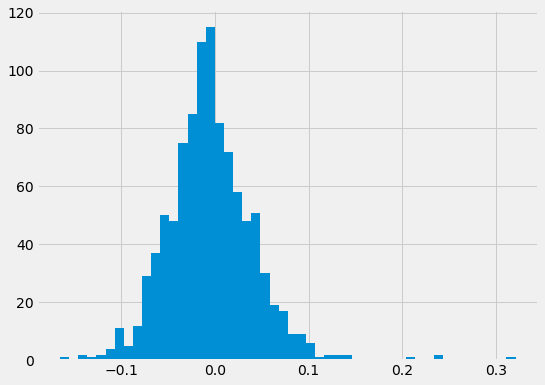

In [9]:
ts_df["aapl_returns"].hist(bins=50, figsize=(8,6))

In [10]:
# There are some outliers
# Lets check on what date AAPL had a min and max return

max_date = ts_df.loc[ts_df['aapl_returns'].idxmax()].name
min_date = ts_df.loc[ts_df['aapl_returns'].idxmin()].name

print ("The max value for aapl was recorded on {} while the min value was recorded on {}".format(max_date, min_date))

The max value for aapl was recorded on 2008-09-26 while the min value was recorded on 2006-07-14


In [11]:
# Now, lets do the same for the S&P returns, and plot them side by side

snp_summary = ts_df["spy_returns"].describe()
snp_summary 

count    999.000000
mean      -0.001434
std        0.024947
min       -0.117327
25%       -0.014145
50%       -0.003155
75%        0.008836
max        0.246780
Name: spy_returns, dtype: float64

## Plot the returns distributions

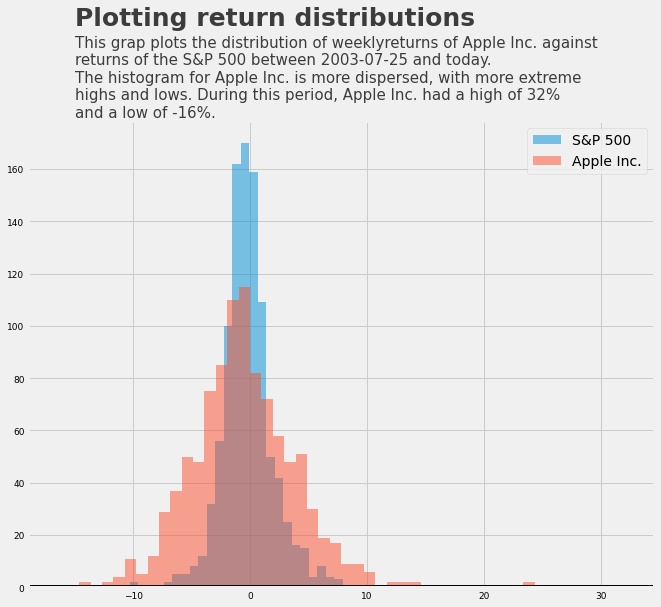

In [12]:
#collapse-hide

style.use('fivethirtyeight')

x = ts_df["spy_returns"] * 100
y = ts_df["aapl_returns"] * 100

plt.hist(x, alpha = 0.5, bins=50, label='S&P 500')
plt.hist(y,alpha = 0.5, bins = 50, label='Apple Inc.')
plt.legend(loc='upper right')
plt.tick_params(axis = 'both', which = 'major', labelsize = 9)
plt.axhline(y = 0, color = 'black', linewidth = 5, alpha = 1)
#plt.xlabel(s = "% return", fontsize = "small")

plt.text(-15, 180, s = """This grap plots the distribution of weeklyreturns of Apple Inc. against 
returns of the S&P 500 between 2003-07-25 and today. 
The histogram for Apple Inc. is more dispersed, with more extreme 
highs and lows. During this period, Apple Inc. had a high of 32%
and a low of -16%.""", fontsize = 15, alpha = .75)

plt.text(-15, 215, s = """Plotting return distributions""", weight = "bold", fontsize = 25, alpha = .75)
plt.show()

## Value at Risk (VaR)
In this section we'll check the VaR numbers for both AAPL and the S&P500. The VaR tell us that we have X % chance of not loosing more than a nominal value in one day.

In [13]:
#collapse-hide

def var_cov_var(P, c, m, sigma):
    """
    Variance-Covariance calculation of weekly Value-at-Risk
    using confidence level c, with mean of returns m
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = norm.ppf(1-c, m, sigma)
    
    return P - P*(alpha + 1)

In [14]:
from scipy.stats import norm

P = 1000000   # 1,000,000 USD
c = 0.99  # 99% confidence interval

aapl_mean = ts_df["aapl_returns"].mean()
aapl_sigma = ts_df["aapl_returns"].std()

snp_mean = ts_df["spy_returns"].mean()
snp_sigma = ts_df["spy_returns"].std()

var_aapl = var_cov_var(P, c, aapl_mean, aapl_sigma)
var_snp = var_cov_var(P, c, snp_mean, snp_sigma)

print ("The one week VaR for Apple on a $1 million portfolio is ${:,.2f}".format(round(var_aapl,2)))
print ("The one week VaR for the S&P 500 on a $1 million portfolio is ${:,.2f}".format(round(var_snp,2)))

The one week VaR for Apple on a $1 million portfolio is $111,966.53
The one week VaR for the S&P 500 on a $1 million portfolio is $59,469.59
